# ProMis - Probabilistic Mission Design

We will start by importing the necessary tools for the experiments.

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
# Plotting and figure settings
# Ignore unimportant warnings in Jupyter
import warnings

import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

# Third Party
from numpy import array
from shapely import intersection
from shapely.geometry import LineString, MultiPolygon, Point, Polygon

# ProMis
from promis.geo import (
    CartesianLocation,
    CartesianMap,
    CartesianPolygon,
    CartesianRoute,
    Geospatial,
    LocationType,
    PolarLocation,
    PolarPolygon,
    RasterBand,
)
from promis.geo.map import PolarMap
from promis.loaders.spatial_loader import SpatialLoader
from promis.logic.spatial import Distance, Over

warnings.filterwarnings("ignore")

In [3]:
"""Allows to find and read nautical charts. Currently, this only supports IHO S-57 charts.

Examples:
    This shows how to recursively read all obstacles/relevant chart objects from a given directory:

    >>> from pyrate.common.charts import ChartFileHandler, S57ChartHandler
    >>> path_to_charts = "stda/data/charts/noaa_vector/data"
    >>> # Nothing about this is is specific to the `S57ChartHandler`, so cast it to `ChartFileHandler`
    >>> handler: ChartFileHandler = S57ChartHandler()
    >>> polygons = [ #doctest: +SKIP
    ...     handler.read_chart_file(chart_file)
    ...     for chart_file in handler.find_chart_files(path_to_charts)
    ... ]

Ideas:
    - Maybe use `Fiona <https://pypi.org/project/Fiona/>`__ as an alternative?

Resources:
    - Documentation on the S-57 file format and the relevant parts of GDAL:
        - https://gdal.org/python/osgeo.ogr-module.html
        - https://gdal.org/drivers/vector/s57.html
        - https://www.teledynecaris.com/s-57/frames/S57catalog.htm (the entire object catalogue!)
        - https://gdal.org/api/python_gotchas.html (!)
    - Examples and Cookbooks:
        - https://pcjericks.github.io/py-gdalogr-cookbook/vector_layers.html
        - and more general: https://pcjericks.github.io/py-gdalogr-cookbook/index.html
        - https://lists.osgeo.org/pipermail/gdal-dev/2008-April/016767.html
    - Helpers:
        - The program QGIS is very helpful because it can open S-57 files visually.
"""

# Python standard
import os
import os.path
import sys
from abc import ABC, abstractmethod
from collections.abc import Generator, Mapping
from hashlib import sha1
from pathlib import Path

# Typing
from warnings import catch_warnings, simplefilter, warn

# Allow osgeo to be missing
# Set to True if the osgeo is available, or False if not
_OSGEO_PRESENT: bool
try:
    # This emits warnings (at least on Python 3.8)
    with catch_warnings():
        simplefilter("ignore", DeprecationWarning, lineno=8)
        from osgeo import gdal, ogr
except ImportError as _error:  # pragma: no cover
    _OSGEO_PRESENT = False
    warn(
        "Could not import package osgeo. Please install it as described in the README. "
        f"Error was: {_error}"
    )
    del _error
else:
    _OSGEO_PRESENT = True
    ogr.UseExceptions()


#: Currently there are only locations and polygons, see :meth:`S57ChartHandler._create_obstacle`
PolarChartGeometry = PolarLocation | PolarPolygon


class S57ChartHandler:
    """Reads IHO S-57 chart files. The returned geometries are *not* checked for validity.

    These chart objects are extracted from the source files:

      - Landmasses (from S-57 object type ``LNAM``)
      - Depth values (from S-57 object type ``DEPARE``, via attribute ``DRVAL2``, assumed to be in meters)
      - Buoys (from S-57 object type ``BOY*``, e.g. ``BOYCAR``)
      - Possibly more in the future

    The identifiers of the created objects are created deterministically from the chart name and the already
    contained identifiers. They are supposed to be unique across all charts. They are created by first
    assembling a string that is guaranteed to be a globally unique identifier from the chart file name and the
    ``LNAM`` field. Then, the string is hashed and truncated to form a 63-bit identifier.

    The names of the objects are created like this:
    ``{chart file name}#{chart-unique alphanumeric identifier} ({human-readable type}): "{common name}"``.

    All objects are associated with the applicable :class:`pyrate.plan.geometry.LocationType`.

    Raises:
        ImportError: If the :mod:`osgeo` package is missing
    """

    def __init__(self):
        if not _OSGEO_PRESENT:  # pragma: no cover
            raise ImportError('the "osgeo" package must be installed for this handler to function')

    #: This maps layer names to the corresponding parameters for S57ChartHandler._create_obstacle(...)
    #: These are not all objects but merely the ones which are trivial to map.
    _SIMPLE_MAPPINGS: Mapping[str, tuple[LocationType, str]] = {
        "LNDARE": (LocationType.LAND, "Landmass"),
        #
        "BOYCAR": (LocationType.OBSTRUCTION, "Buoy (BOYCAR)"),
        "BOYINB": (LocationType.OBSTRUCTION, "Buoy (BOYINB)"),
        "BOYISD": (LocationType.OBSTRUCTION, "Buoy (BOYISD)"),
        "BOYLAT": (LocationType.OBSTRUCTION, "Buoy (BOYLAT)"),
        "BOYSAW": (LocationType.OBSTRUCTION, "Buoy (BOYSAW)"),
        "BOYSPP": (LocationType.OBSTRUCTION, "Buoy (BOYSPP)"),
        #
        "OBSTRN": (LocationType.OBSTRUCTION, "Obstruction"),
        "OFSPLF": (LocationType.OBSTRUCTION, "Platform"),
        "OSPARE": (LocationType.OBSTRUCTION, "Production Area/Wind farm"),
        "PILPNT": (LocationType.OBSTRUCTION, "Post"),
        "MIPARE": (LocationType.OBSTRUCTION, "Military Exercise Area"),
        "DMPGRD": (LocationType.OBSTRUCTION, "Dumping Ground"),
        "DOCARE": (LocationType.OBSTRUCTION, "Dock Area"),
        "DRYDOC": (LocationType.OBSTRUCTION, "Dry Dock"),
        "FLODOC": (LocationType.OBSTRUCTION, "Floating Dock"),
        "DYKCON": (LocationType.OBSTRUCTION, "Dyke/Levee"),
        #
        "DWRTPT": (LocationType.WATER_ROUTE, "Deep Water Way"),  # primary
        # "DWRTCL": (LocationType.WATER_ROUTE, "Deep Water Way (Centerline)"),  # primary
        "FAIRWY": (LocationType.WATER_ROUTE, "Fairway"),  # secondary
        #
        "ACHARE": (LocationType.ANCHORAGE, "Anchorage Area"),
        # In parctice, one would also want to parse ACHBRT (single ship anchorage) with the corresponding radius
    }

    @staticmethod
    def find_chart_files(
        search_path: str | os.PathLike[str],
    ) -> Generator[Path, None, None]:
        for root, _, files in os.walk(str(search_path), followlinks=True):
            for file in files:
                if file.endswith(".000"):
                    # assume it is an IHO S-57 file
                    yield Path(root) / file
                # else: ignore the file

    def read_chart_file(
        self, path: str | os.PathLike[str]
    ) -> Generator[PolarChartGeometry, None, None]:
        """Reads a chart file and converts the relevant layers/features into ChartObstacles.

        Args:
            path: The path to the S-57 chart file (e.g. ``something.000``)

        Returns:
            All relevant obstacles with globally unique and deterministic names

        Raises:
            FileNotFoundError: If the database file(s) is/are missing
            OSError: If the database file(s) cannot be opened for another reason
        """
        file_path = str(path)

        if not os.path.exists(file_path):
            raise FileNotFoundError(f"cannot open dataset: {file_path}")

        # open database
        dataset = ogr.Open(file_path, gdal.GA_ReadOnly)
        if not dataset:
            raise OSError(f"cannot open dataset (invalid file): {file_path}")

        file_name = os.path.splitext(os.path.basename(file_path))[0]
        file_name_bytes = file_name.encode()

        # read contents
        for i in range(int(dataset.GetLayerCount())):
            layer = dataset.GetLayerByIndex(i)
            for geometry, feature_id in S57ChartHandler._convert_layer_to_obstacles(layer):
                # prepend the name of the file to make it unique and ease lookup of objects in the source
                # this is also required because the LNAM field is not guaranteed to be unique across files
                geometry.name = f"{file_name}#{geometry.name}"

                # hash a combination of file name and feature identifier as that together is globally unique
                hashed_id = sha1(file_name_bytes + feature_id.encode()).digest()
                # truncate to 64 bit and create an int from it
                identifier = int.from_bytes(hashed_id[-8:], sys.byteorder, signed=True)
                # cut off the most-significant bit to arrive at 63 bits
                geometry.identifier = identifier & 0x7F_FF_FF_FF_FF_FF_FF_FF

                yield geometry

    @staticmethod
    def _convert_layer_to_obstacles(
        layer: ogr.Layer,
    ) -> Generator[tuple[PolarChartGeometry, str], None, None]:
        """Converts the relevant obstacles of a layer into :attr:`s57_files.PolarChartGeometry`.

        Args:
            layer: The layer to search in

        Returns:
            For each relevant feature in the layer: a polygon and a feature ID (32 bit)
        """

        layer_name = layer.GetName()

        # we first do the more complicated stuff and then convert using S57ChartHandler.SIMPLE_MAPPINGS

        if layer_name == "DEPARE":  # "depth area"
            for feature in layer:
                # Warning: we assume these depths are given in meters, which could be wrong in some cases but
                # worked in our tests
                depth_max = feature["DRVAL2"]
                yield from S57ChartHandler._create_obstacle(
                    feature, f"Depth={depth_max}m", LocationType.WATER
                )
        else:
            if layer_name in S57ChartHandler._SIMPLE_MAPPINGS:
                location_type, human_readable_type = S57ChartHandler._SIMPLE_MAPPINGS[layer_name]
                for feature in layer:
                    yield from S57ChartHandler._create_obstacle(
                        feature, human_readable_type, location_type
                    )

    @staticmethod
    def _create_obstacle(
        feature: ogr.Feature,
        human_readable_type: str,
        location_type: LocationType,
    ) -> Generator[tuple[PolarChartGeometry, str], None, None]:
        """Creates a point or area obstacle from a given feature.

        Args:
            feature: The feature to transform
            human_readable_type: A human-readable string describing what this is, like ``"landmass"``
            location_type: The location type to be used

        Returns:
            (1) A location or polygon that represents an obstacle
            (2) A (not necessarily unique) feature ID (32 bit) for that obstacle; but unique per chart file
        """

        # This ID is guaranteed to be unique within the chart file and composed of AGEN, FIDN, and FIDS
        feature_id: str = feature["LNAM"]
        assert feature_id is not None, "the LNAM field is mandatory for all objects"

        # Remark: feature.IsFieldSetAndNotNull("OBJNAM") seems to work but logs tons of errors to syserr
        # It is not mandatory for all types of chart objects
        object_name: str | None
        try:
            object_name = feature["OBJNAM"]  # might be None
        except (ValueError, KeyError):
            object_name = None

        if object_name is None:
            object_name = "---"
        else:
            # Replace broken unicode text (surrogates)
            object_name = object_name.encode("utf-8", "replace").decode("utf-8")

        # Construct the obstacle's name
        name = f'{feature_id} ({human_readable_type}): "{object_name}"'

        # Extract the geometries (as the feature may or may not contain a geometry collection)
        geometry = feature.GetGeometryRef()
        geometry_type = geometry.GetGeometryType()

        if geometry_type == ogr.wkbPoint:
            point = PolarLocation(
                latitude=geometry.GetY(),
                longitude=geometry.GetX(),
                name=name,
                location_type=location_type,
            )
            yield point, feature_id

        elif geometry_type == ogr.wkbLineString:
            # Ignore this feature as there are currently no feature being extracted that are
            # LineStrings and relevant for navigation
            # TODO(Someone): One should verify that this is okay; See #125
            warn(f"Ignoring LineString geometry in chart: {name}")

        elif geometry_type == ogr.wkbPolygon:
            # TODO(Felix): We throw away the inner rings (i.e. the holes); See #106
            outer_ring = geometry.GetGeometryRef(0)
            points = [
                PolarLocation(latitude=lat, longitude=lon) for lon, lat in outer_ring.GetPoints()
            ]
            yield PolarPolygon(points, name=name, location_type=location_type), feature_id

        else:
            # Apparently, no other geometries appear in charts
            raise NotImplementedError(
                f"Cannot handle geometry type {ogr.GeometryTypeToName(geometry_type)}"
            )


class NauticalChartSpatialLoader(SpatialLoader):
    def __init__(self, chart_root: Path) -> None:
        super().__init__()

        self.chart_root = chart_root
        assert chart_root.exists(), f"chart_root must exist, but got {chart_root}"
        assert chart_root.is_dir(), f"chart_root must be a directory, but got {chart_root}"

    def load_polar(self, origin: PolarLocation, width: float, height: float) -> PolarMap:
        return self.load_cartesian(origin, width, height).to_polar()

    def load_cartesian(self, origin: PolarLocation, width: float, height: float) -> CartesianMap:
        handler = S57ChartHandler()

        bounding_box = CartesianPolygon(
            [
                # clockwise: top-left, ...
                CartesianLocation(east=-width / 2, north=height / 2),
                CartesianLocation(east=width / 2, north=height / 2),
                CartesianLocation(east=width / 2, north=-height / 2),
                CartesianLocation(east=-width / 2, north=-height / 2),
            ]
        )

        def from_shapely(
            shapely_geometry, copy_metadata_from: Geospatial | None = None
        ) -> Generator[CartesianLocation, None, None]:
            """Constructs an appropriate geometry from a Shapely geometry object.

            Args:
                shapely_geometry: The geometry to convert. Supported types are Point, LineString, Polygon, and MultiPolygon.
                copy_metadata_from: The geometry to copy metadata from, or None to not copy metadata.

            Returns:
                The constructed geometry.
            """
            reference = copy_metadata_from or CartesianLocation(0, 0)  # for defaults

            if isinstance(shapely_geometry, Point):
                yield CartesianLocation(
                    east=shapely_geometry.x,
                    north=shapely_geometry.y,
                    name=reference.name,
                    location_type=reference.location_type,
                    identifier=reference.identifier,
                )
            elif isinstance(shapely_geometry, LineString):
                yield CartesianRoute.from_numpy(
                    array(shapely_geometry.coords).T,
                    name=reference.name,
                    location_type=reference.location_type,
                    identifier=reference.identifier,
                )
            elif isinstance(shapely_geometry, Polygon):
                yield CartesianPolygon.from_numpy(
                    array(shapely_geometry.exterior.coords).T,
                    # TODO holes?
                    name=reference.name,
                    location_type=reference.location_type,
                    identifier=reference.identifier,
                )
            elif isinstance(shapely_geometry, MultiPolygon):
                for polygon in shapely_geometry.geoms:
                    yield from from_shapely(polygon, reference)

        def generate() -> Generator[PolarChartGeometry, None, None]:
            for file in handler.find_chart_files(self.chart_root):
                for geo_object in handler.read_chart_file(file):
                    geometry = geo_object.to_cartesian(origin=origin)

                    cropped = intersection(bounding_box.geometry, geometry.geometry)

                    # yield CartesianPolygon(
                    #     locations=[
                    #         # make a W
                    #         CartesianLocation(-100, -100),
                    #         CartesianLocation(-100, 100),
                    #         CartesianLocation(30, -50),
                    #         CartesianLocation(100, 100),
                    #         CartesianLocation(100, -100),
                    #     ],
                    #     location_type=LocationType.LAND,
                    # )
                    # return

                    if not cropped.is_empty:
                        yield from from_shapely(cropped, copy_metadata_from=geometry)

        return CartesianMap(
            origin=origin,
            width=width,
            height=height,
            features=list(generate()),
        )


loader = NauticalChartSpatialLoader(chart_root=Path("data") / "us_charts")

origin = PolarLocation(latitude=41.5188, longitude=-70.6777)
dimensions = (2000, 2000)
experiment_map = loader.load_cartesian(origin=origin, width=dimensions[0], height=dimensions[1])

print(f"Loaded {len(experiment_map.features)} features")

In [ ]:
for feature in experiment_map.features:
    print(f"{feature.location_type.name}: \t{feature.name}")

WATER: 	US4MA23M#0226023E3EE8FB90 (Depth=1.8m): "---"
WATER: 	US4MA23M#0226023E3B97FB90 (Depth=5.4m): "---"
WATER: 	US4MA23M#0226023E40FBFB90 (Depth=3.6m): "---"
WATER: 	US4MA23M#0226023E40FBFB90 (Depth=3.6m): "---"
WATER: 	US4MA23M#0226023E3E30FB90 (Depth=5.4m): "---"
WATER: 	US4MA23M#0226023E410EFB90 (Depth=0.0m): "---"
WATER: 	US4MA23M#0226023E3E18FB90 (Depth=0.0m): "---"
WATER: 	US4MA23M#0226023E38FEFB90 (Depth=9.1m): "---"
WATER: 	US4MA23M#0226023E4142FB90 (Depth=3.6m): "---"
WATER: 	US4MA23M#0226023E40DAFB90 (Depth=1.8m): "---"
LAND: 	US4MA23M#0226023E3D4CFB90 (Landmass): "---"
LAND: 	US4MA23M#0226023E3D4CFB90 (Landmass): "---"
LAND: 	US4MA23M#0226023E3BDCFB90 (Landmass): "Nonamesset Island"
LAND: 	US4MA23M#0226023E3FB1FB90 (Landmass): "---"
LAND: 	US4MA23M#0226023E3CF7FB90 (Landmass): "---"
LAND: 	US4MA23M#0226023E574EFB90 (Landmass): "---"
LAND: 	US4MA23M#0226023E57B9FB90 (Landmass): "---"
LAND: 	US4MA23M#0226023E57ACFB90 (Landmass): "---"
LAND: 	US4MA23M#0226023E57B3FB90 (Land

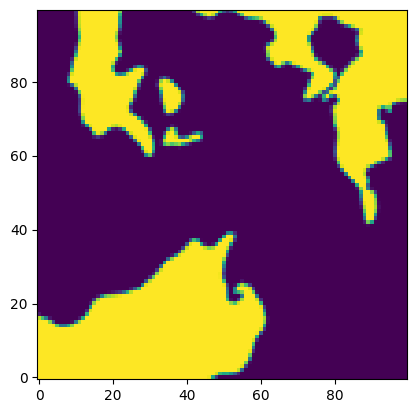

In [ ]:
band = RasterBand.from_map(
    experiment_map,
    location_type=LocationType.LAND,
    resolution=(100, 100),
)
plt.imshow(band.data[::-1, :], origin="lower")
pass

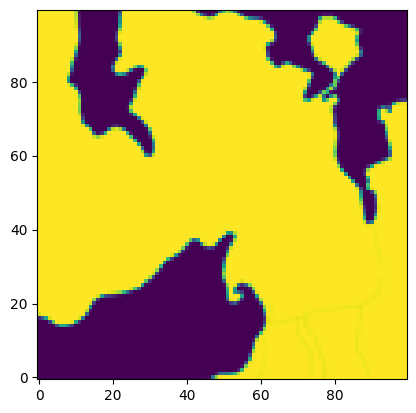

In [ ]:
band = RasterBand.from_map(
    experiment_map,
    location_type=LocationType.WATER,
    resolution=(100, 100),
)
plt.imshow(band.data[::-1, :], origin="lower")
pass

In [ ]:
from promis import ProMis

# ProMis Parameters
dimensions = (1_000.0, 1_000.0)  # Meters
resolution = (100, 100)
spatial_samples = 10  # How many maps to generate to compute statistics
types = [  # Which types to load and compute relations for
    # LocationType.PARK,
    # LocationType.PRIMARY,
    # LocationType.SECONDARY,
    # LocationType.TERTIARY,
    # ...
    LocationType.LAND,
]

### min_deep(location, 5)
### depth(location) tilde normal(mean, var).
### depth(location) < 5

# Setup engine
pmd = ProMis(origin, dimensions, resolution, types, spatial_samples)
pmd.map = experiment_map
pmd.compute_distributions(None, cache=".promis_cache")

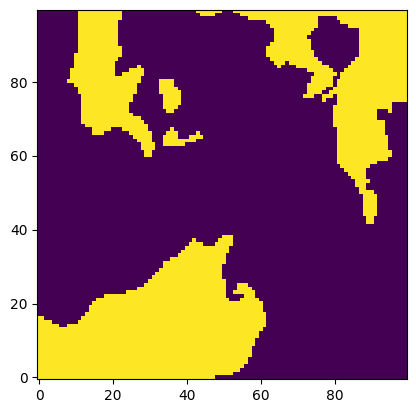

In [ ]:
image = pmd.overs[LocationType.LAND].probability.data.T[::-1, :]
plt.imshow(image, origin="lower")
pass

'Time taken: 0.11s program, 0.02s compile, 4.12s inference'

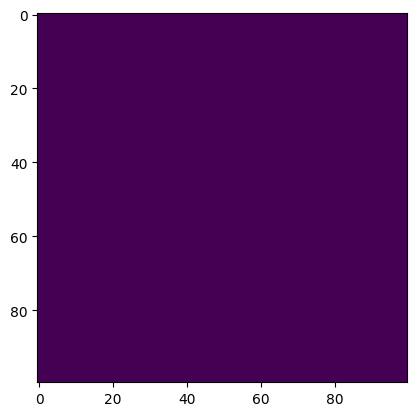

In [ ]:
# Generate landscape
# with open("movement.pl") as model_file:
#     landscape, time = pmd.generate(logic=model_file.read(), n_jobs=8, batch_size=64)

model_code = """
landscape(R, C) :- depth(R, C) > 5.
"""
landscape, program_time, compile_time, inference_time = pmd.generate(
    logic=model_code, n_jobs=8, batch_size=64
)

# Show result
plt.imshow(landscape.data.T)

f"Time taken: {program_time:.2f}s program, {compile_time:.2f}s compile, {inference_time:.2f}s inference"